[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


DATASET LOADED SUCCESSFULLY!

                  category  rating  label  \
0                  Grocery       1      1   
1                   Beauty       4      0   
2               Appliances       4      1   
3                   Beauty       3      0   
4  Computers & Accessories       2      0   

                                                text review_type  
0  This changed my life completely unbelievable p...        Fake  
1  I have been using it for a month and it works ...     Genuine  
2   I love this so much super great awesome perfect!        Fake  
3   Satisfied with the purchase, delivery was quick.     Genuine  
4               Great value and amazing performance.     Genuine  

=========== MODEL RESULTS ===========

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       1.00      1.00      1.00       204

    accuracy                           1.00       400


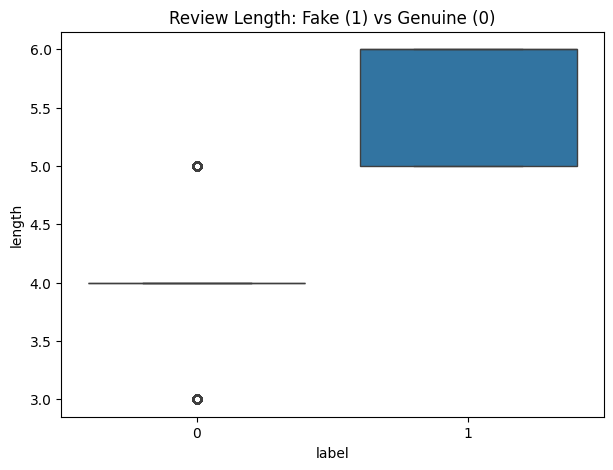

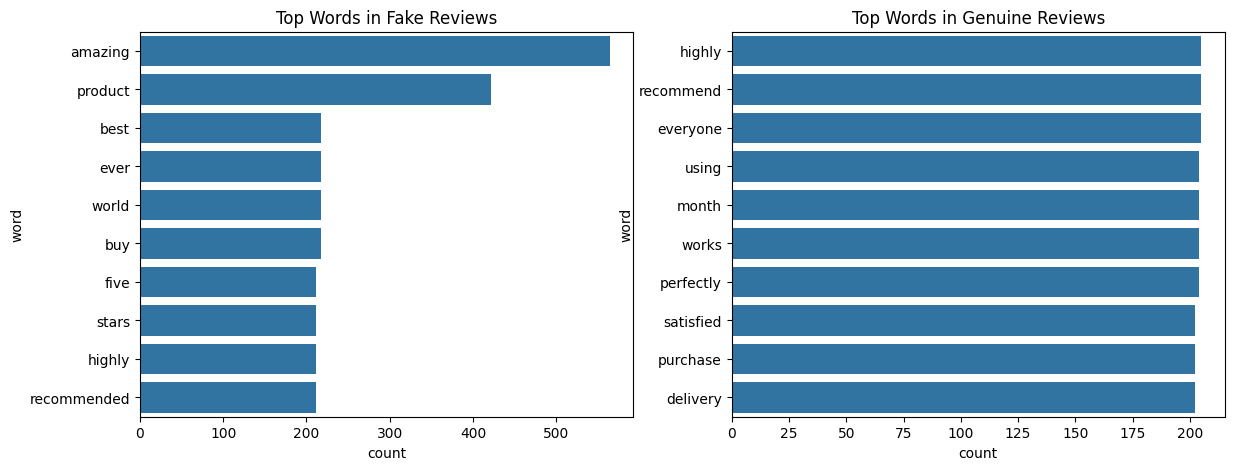

In [ ]:
# ============================================================
# FULL WORKING CODE FOR FAKE vs GENUINE REVIEW DETECTION
# ============================================================

!pip install nltk scikit-learn pandas numpy matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')   # FIX FOR YOUR ERROR
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# ============================================================
# LOAD DATASET
# ============================================================

df = pd.read_csv("/content/custom_review_dataset_with_text_labels (6) (1).csv")
print("DATASET LOADED SUCCESSFULLY!\n")
print(df.head())


# ============================================================
# TEXT CLEANING
# ============================================================

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub("[^a-zA-Z ]", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)


# ============================================================
# TRAIN-TEST SPLIT
# ============================================================

X = df["clean_text"]
y = df["label"]   # Fake = 1, Genuine = 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# ============================================================
# TF–IDF
# ============================================================

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)


# ============================================================
# TRAIN MODEL
# ============================================================

model = LogisticRegression(max_iter=1200)
model.fit(X_train_tf, y_train)


# ============================================================
# EVALUATION
# ============================================================

pred = model.predict(X_test_tf)

print("\n=========== MODEL RESULTS ===========\n")
print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))


# ============================================================
# EXPLAIN REVIEW FUNCTION
# ============================================================

def explain_review(text):
    clean = clean_text(text)
    tfidf_vec = tfidf.transform([clean])
    prediction = model.predict(tfidf_vec)[0]
    prob = model.predict_proba(tfidf_vec)[0][1]

    explanation = []

    # Length rule
    if len(clean.split()) < 8:
        explanation.append("Short review → likely fake")
    else:
        explanation.append("Detailed review → likely genuine")

    # Exaggeration words rule
    positive_words = ["amazing","awesome","best","perfect","unbelievable","fantastic","excellent","great"]
    pos_count = sum([1 for w in clean.split() if w in positive_words])

    if pos_count >= 2:
        explanation.append("Too many exaggerated words → suspicious")

    # Detailed expression rule
    if len(clean.split()) > 12 and pos_count == 0:
        explanation.append("Contains real details → looks genuine")

    return prediction, prob, explanation


# ============================================================
# SAMPLE PREDICTIONS (5 REVIEWS)
# ============================================================

print("\n=========== SAMPLE PREDICTIONS ===========\n")

samples = X_test.sample(5)

for review in samples:
    pred, prob, reason = explain_review(review)
    print("\nReview:", review)
    print("Prediction:", "FAKE" if pred == 1 else "GENUINE")
    print("Probability Fake:", round(prob, 3))
    print("Reason(s):")
    for r in reason:
        print(" -", r)


# ============================================================
# VISUAL 1 — REVIEW LENGTH GRAPH
# ============================================================

df["length"] = df["clean_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,5))
sns.boxplot(x=df["label"], y=df["length"])
plt.title("Review Length: Fake (1) vs Genuine (0)")
plt.show()


# ============================================================
# VISUAL 2 — TOP WORDS
# ============================================================

from collections import Counter

fake_words = Counter(" ".join(df[df["label"]==1]["clean_text"]).split()).most_common(10)
gen_words  = Counter(" ".join(df[df["label"]==0]["clean_text"]).split()).most_common(10)

fake_df = pd.DataFrame(fake_words, columns=["word","count"])
gen_df  = pd.DataFrame(gen_words,  columns=["word","count"])

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.barplot(x="count", y="word", data=fake_df)
plt.title("Top Words in Fake Reviews")

plt.subplot(1,2,2)
sns.barplot(x="count", y="word", data=gen_df)
plt.title("Top Words in Genuine Reviews")

plt.show()
